### Continuous Systems Netket
Bosons in a 3D Harmonic trap
Starting with - https://netket.readthedocs.io/en/latest/tutorials/gs-continuous-space.html

In [1]:
import jax.numpy as jnp
import netket.experimental as nkx
import netket as nk

N = 10
geo = nkx.geometry.FreeSpace(d=3)
hi = nkx.hilbert.Particle(N=N, geometry=geo)

∣NK⟩ Tip: Prefer the new nk.driver.VMC_SR over VMC which supports minSR and SPRING.

In [2]:
sa = nk.sampler.MetropolisGaussian(hi, sigma=0.1, n_chains=16, sweep_size=32)

In [3]:
### Hamiltonian
ekin = nk.operator.KineticEnergy(hi, mass=1.0)  # nabla square

# Potential energy needs to be defined
def v(x):
    return 0.5 * jnp.linalg.norm(x) ** 2

pot = nk.operator.PotentialEnergy(hi, v)

ha = ekin + pot

In [9]:
### Defining Gaussian Ansatz
# Product of gaussians centred at 0 is the ground state

import flax.linen as nn
from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import normal

from netket.utils.types import DType, Array, NNInitFunc


class Gaussian(nn.Module):
    param_dtype: DType = jnp.float64
    kernel_init: NNInitFunc = normal(stddev=1.0)

    @nn.compact
    def __call__(self, x_in: Array):
        nv = x_in.shape[-1]

        kernel = self.param("kernel", self.kernel_init, (nv, nv), self.param_dtype)
        kernel = jnp.dot(kernel.T, kernel)

        kernel, x_in = promote_dtype(kernel, x_in, dtype=None)
        y = -0.5 * jnp.einsum("...i,ij,...j", x_in, kernel, x_in)  # No idea how this works

        return y

In [10]:
Gauss = Gaussian()
vstate = nk.vqs.MCState(sa, Gauss, n_samples=4096, n_discard_per_chain=100)

In [12]:
### Optimization
vstate.init_parameters(normal(stddev=1.0))

optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(ha, optimizer, variational_state=vstate)

log = nk.logging.RuntimeLog()
gs.run(n_iter=150, out=log)

energy = vstate.expect(ha)
error = jnp.abs(energy.mean - 15.0) / 15.0
print(energy, error)

  0%|                                                                  | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

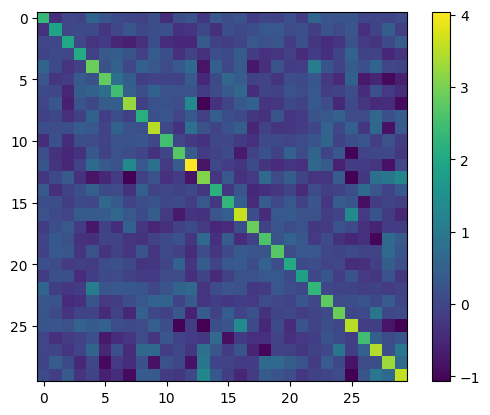

In [15]:
import matplotlib.pyplot as plt
kernel = vstate.parameters["kernel"]
plt.imshow(jnp.dot(kernel.T, kernel))
plt.colorbar()

In [ ]:
### Defining Atomic hamiltonian